In [4]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline
import numpyro
import pyro.distributions as dist
import numpyro
import numpyro.distributions as n_dist
matplotlib.use('TkAgg')
import PyQt5
import skimage.morphology as morph
import skimage

In [2]:
timeResolution = np.array([25, 16, 17, 15, 15, 17, 14])
minTimeResolution = min(timeResolution)
n_frames = np.array([14516, 4372, 4625, 4078, 3983, 4943, 4593])

def downsampleTimeResolution(timeResolution,minTimeResolution,n_frames,flag):
    indices = np.round(np.linspace(0,timeResolution-1,minTimeResolution)).astype(int)
    downsample = np.zeros([timeResolution])
    downsample[indices] = 1
    if flag==1:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution))) # returns boolean array
        print(downsampleFrames.shape)
        return downsampleFrames
    
    else:
        downsampleFrames = np.hstack([downsample]*int(np.floor(n_frames/timeResolution)))
        downsampleFramesIdx = np.where(downsampleFrames==1) # return indices of frames to sample in video
        print(downsampleFramesIdx[0].shape)
        return downsampleFramesIdx

In [3]:
videosList=[]

for vidIdx in range(len(timeResolution)):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    n_frames = int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT))
    sampleFrames = downsampleTimeResolution(timeResolution[vidIdx],minTimeResolution,n_frames,1)
    print(sampleFrames.shape)
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened() and frameIdx<sampleFrames.shape[0]):
        ret, frame = vidCv2.read()
        if ret == True and sampleFrames[frameIdx]:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))

    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()


(14500,)
(14500,)
volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

(4368,)
(4368,)
volunteer02.mp4:

number of frames: 4372
frame size: 712 x 480 

(4624,)
(4624,)
volunteer03.mp4:

number of frames: 4625
frame size: 700 x 480 

(4065,)
(4065,)
volunteer04.mp4:

number of frames: 4078
frame size: 720 x 540 

(3975,)
(3975,)
volunteer05.mp4:

number of frames: 3983
frame size: 720 x 540 

(4930,)
(4930,)
volunteer06.mp4:

number of frames: 4943
frame size: 672 x 480 

(4592,)
(4592,)
volunteer07.mp4:

number of frames: 4593
frame size: 500 x 480 



In [4]:
# Example on how to visualize frames in a video

videoIdx = 1 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videosList[videoIdx][:noFrames]
for vid in range(noFrames):
    plt.imshow(vidShow[vid],cmap='gray')
    plt.show()
    clear_output(wait=True)

In [5]:
# Switch to interactive mode
#%matplotlib qt 

# ptsList=[]
# for vidIdx in range(len(videosList)):
#     plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
#     pts=plt.ginput(4)
#     ptsList.append(np.array(pts))
#     plt.show()
#     plt.close()
# ptsArray = np.array(ptsList).astype(np.float32)
# np.savez('transPts',ptsArray)

# Switch back to inline mode
#%matplotlib inline 

In [6]:
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [1]:
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

NameError: name 'videosList' is not defined

### Mask videos with binary morphology

In [ ]:
disk = np.zeros((40,40))
element = skimage.draw.disk((20,20),9,shape=(40,40))
disk[element]=1

morphsInput = []
videoMasks = []
videosTransMaskList = []
for vidIdx,vid in enumerate(videosTransList):
    vidThr = np.zeros(vid.shape[1:])
    for frameIdx,frame in enumerate(vid):
        vidThr+=frame>10
    morphInput=vidThr>0
    vidMask = morph.opening(morphInput,disk) # First opening
    vidMask = morph.closing(vidMask,disk) # Then closing
    morphsInput.append(morphInput)
    videoMasks.append(vidMask)
    videosTransMaskList.append(vid*vidMask[None,:,:])

Text(0.5, 1.0, 'Final processed video')

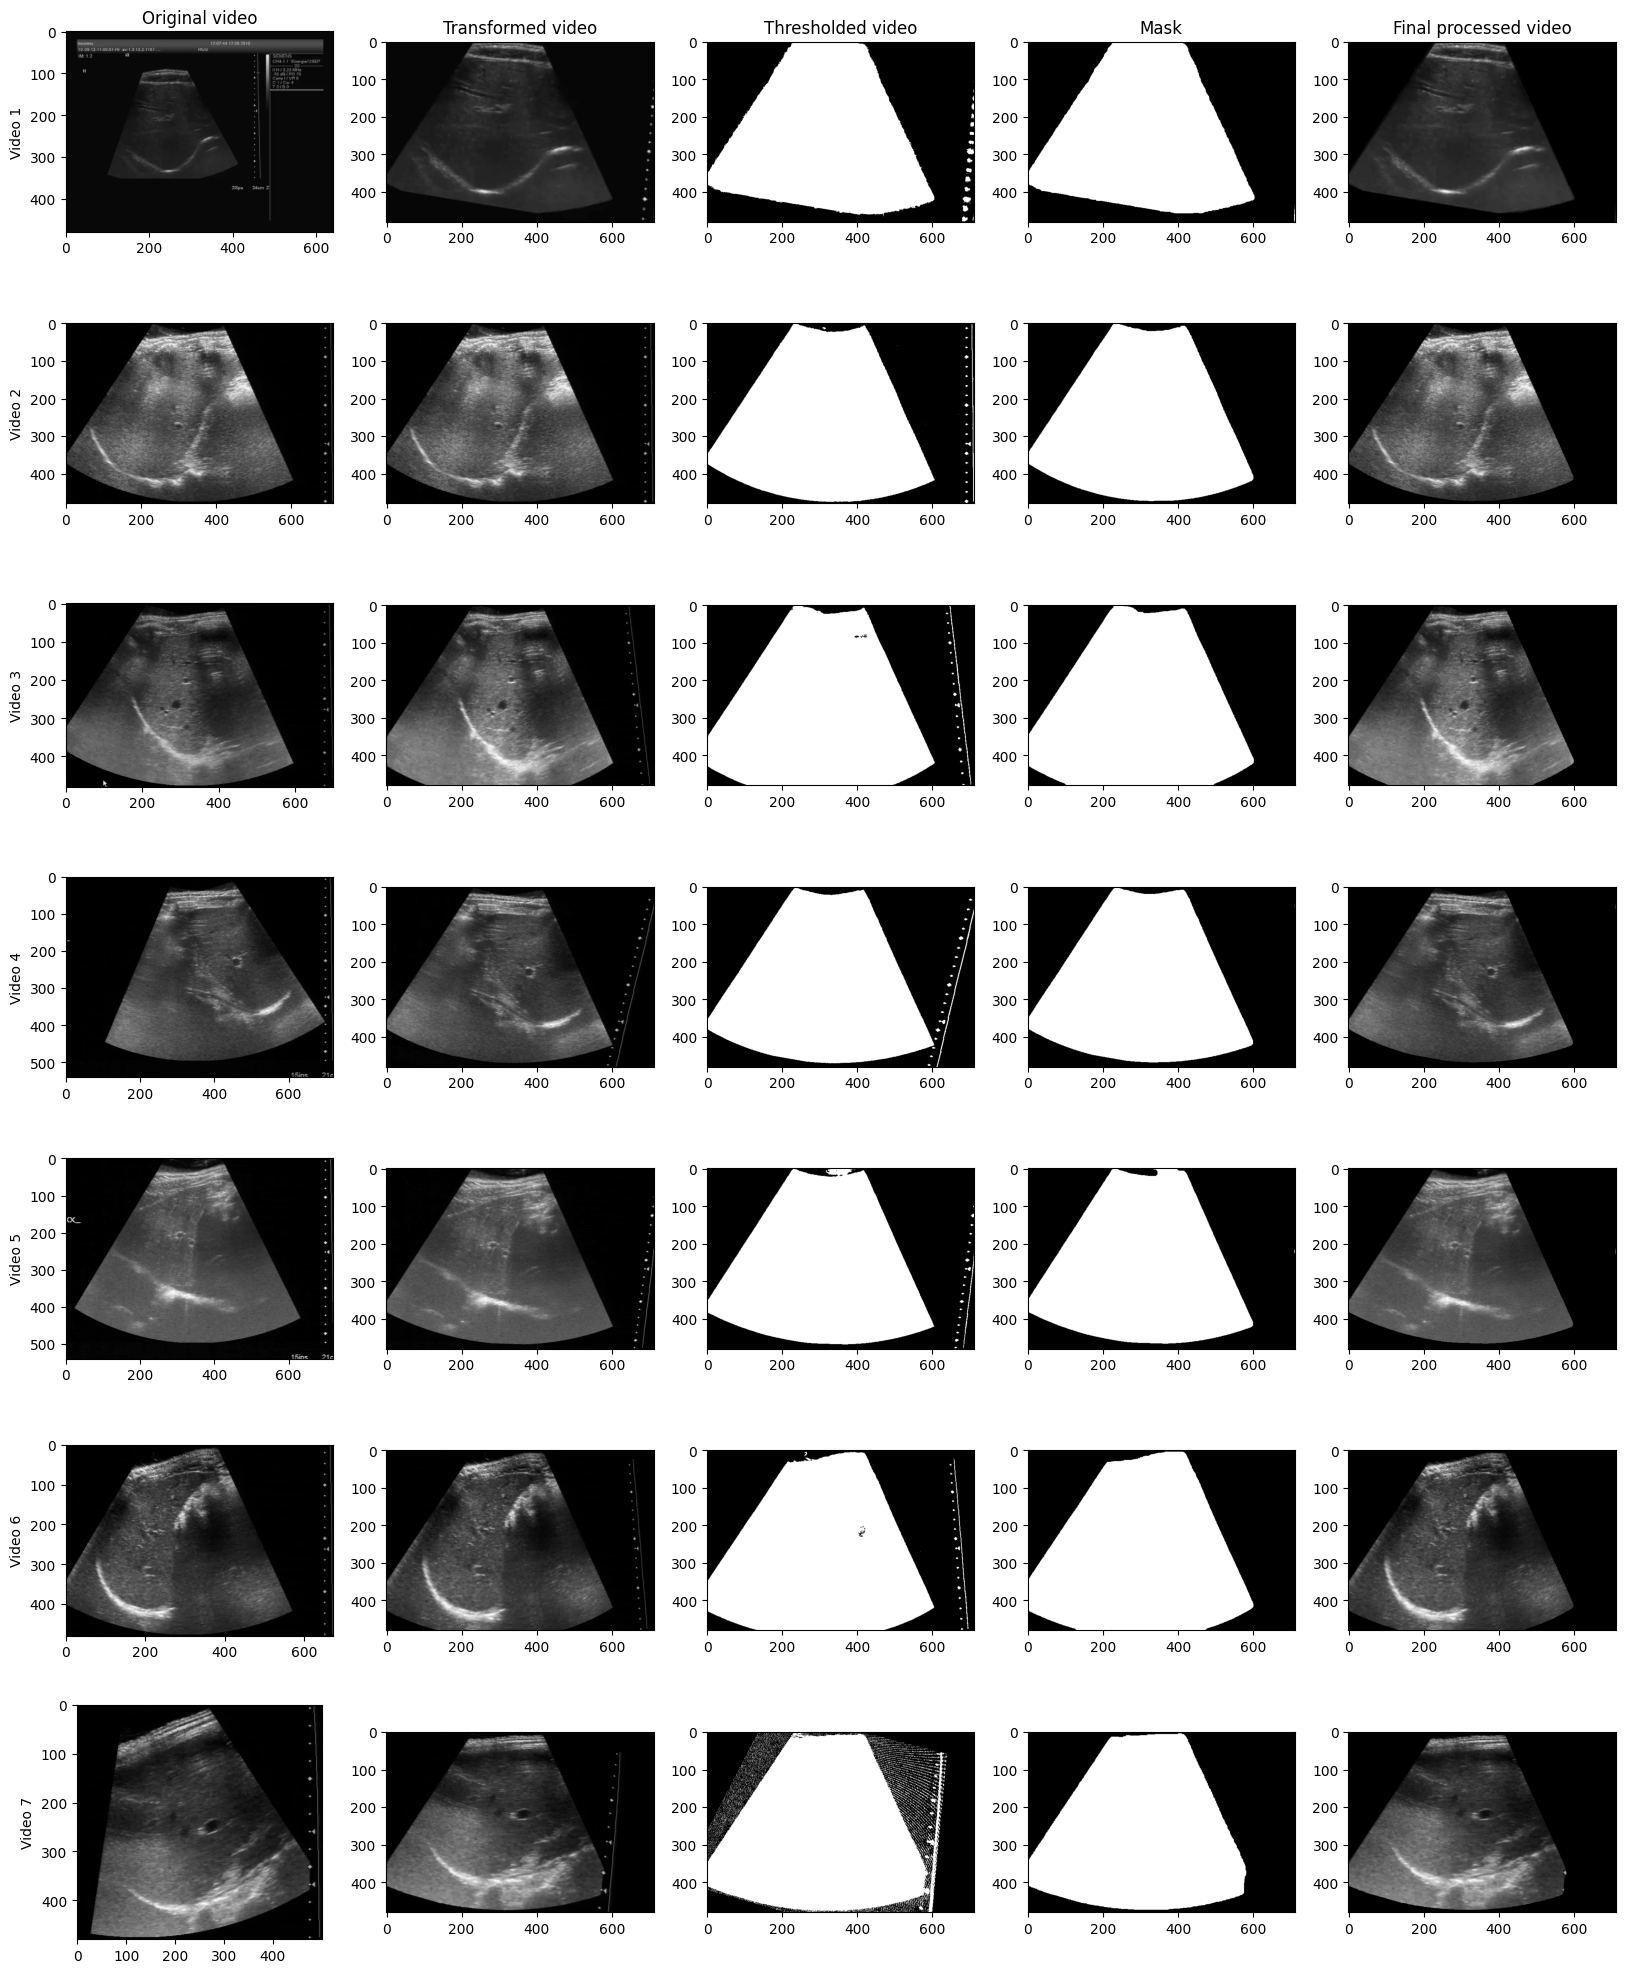

In [ ]:
fig,ax = plt.subplots(7,5,figsize=(20,25))
for vidIdx in range(len(videosList)):
        ax[vidIdx,0].imshow(videosList[vidIdx][0],cmap='gray')
        ax[vidIdx,1].imshow(videosTransList[vidIdx][0],cmap='gray')
        ax[vidIdx,2].imshow(morphsInput[vidIdx],cmap='gray')
        ax[vidIdx,3].imshow(videoMasks[vidIdx],cmap='gray')
        ax[vidIdx,4].imshow(videosTransMaskList[vidIdx][0],cmap='gray')
        ax[vidIdx,0].set_ylabel(f'Video {vidIdx+1}')
ax[0,0].set_title('Original video')
ax[0,1].set_title('Transformed video')
ax[0,2].set_title('Thresholded video')
ax[0,3].set_title('Mask')
ax[0,4].set_title('Final processed video')


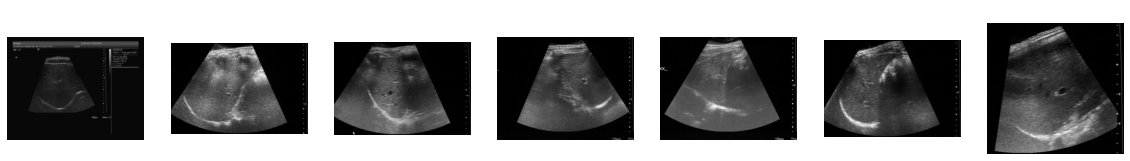

In [ ]:
# plot the first frame of each video in videosList in subplots
fig, axs = plt.subplots(1, len(videosList), figsize=(20, 20))
for i in range(len(videosList)):
    axs[i].imshow(videosList[i][0], cmap='gray')
    axs[i].set_title(f'Video {i+1}')
    axs[i].axis('off')
plt.show()


    

In [ ]:
temp = np.zeros((videosList[0].shape[0],640*480))

for idx,frame in enumerate( videosList[0]):
    temp[idx] = frame.ravel()

print(temp.shape)

(1452, 307200)


In [33]:
import jax
import jax.numpy as jnp
from numpyro.distributions import MultivariateNormal, Normal

In [107]:
def f(carry):
    A,z_prev,Q  = carry
    z_t = jax.lax.dot(A,z_prev)+Q
    
    z_prev = z_t
    return (A,h,z_prev,tau),z_t

In [111]:

def model(y):
    T, D = y.shape
    x_size = D
    z_size = 2

    # Define the model parameters
    A = numpyro.sample("A", Normal(jnp.zeros((z_size, z_size)), jnp.ones((z_size, z_size))))
    h  = numpyro.sample("h", Normal(jnp.zeros((z_size, x_size)), jnp.ones((z_size, x_size))))
    Q = numpyro.sample("Q", Normal(jnp.zeros((z_size, z_size)), jnp.ones((z_size, z_size))))
    R = numpyro.sample("R", Normal(jnp.zeros((x_size, x_size)), jnp.ones((x_size, x_size))))

    #noises = numpyro.sample("noises", fn=Normal(jnp.zeros(z_size),jnp.ones(z_size)))

    # Define the latent variables
    z0 = jnp.zeros(z_size)
    zs = [z0]
    carry = (A,z0,Q)
    carry, zs_eval = jax.lax.scan(f,carry,T)
    zs = jnp.concatenate((jnp.array(zs),zs_eval),axis=0)

    
    # Define the observed variables

    numpyro.sample("y_obs", MultivariateNormal(jax.lax.dot(h, zs[:T]), R), obs=y[:T])
    
    return zs

In [109]:
temp = np.array([np.sin(np.linspace(0, 100, 1000)) for i in range(100)])
temp.shape

(100, 1000)

In [110]:
from numpyro.infer import MCMC, NUTS
from jax import random
import time
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run the model using MCMC
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=10, num_warmup=1000)
mcmc.run(rng_key_, temp)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

ValueError: scan got value with no leading axis to scan over: 100.